In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


In [4]:
!pip install torch nibabel torchinfo 'monai[all]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 22.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 26.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 62.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 58.2 MB/s eta 0:00:00:00

In [5]:
pip install torchmetrics


Note: you may need to restart the kernel to use updated packages.


In [6]:
from monai.networks.nets import UNet,UNETR
from monai.networks.layers import Norm
import torchinfo
from monai.losses import SSIMLoss

import zipfile
import random
import os

import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchmetrics.functional import structural_similarity_index_measure
from monai.metrics import DiceMetric
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchinfo
import torch.nn as nn
from typing import Tuple, Union
from monai.networks.blocks import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock
from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.nets import ViT

/opt/conda/lib/python3.10/site-packages/cupy/_environment.py:540: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


**Model : Unet**



In [7]:
class UNETR_Reconstruction(nn.Module):
    """
    Modified UNETR for 3D medical image reconstruction tasks.
    """

    def __init__(
        self,
        in_channels: int,
        img_size: Tuple[int, int, int],
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        pos_embed: str = "perceptron",
        norm_name: Union[Tuple, str] = "instance",
        conv_block: bool = False,
        res_block: bool = True,
        dropout_rate: float = 0.0,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels (e.g., 1 for grayscale MRI).
            img_size: dimension of input image.
            feature_size: dimension of network feature size.
            hidden_size: dimension of hidden layer.
            mlp_dim: dimension of feedforward layer.
            num_heads: number of attention heads.
            pos_embed: position embedding layer type.
            norm_name: feature normalization type and arguments.
            conv_block: bool argument to determine if convolutional block is used.
            res_block: bool argument to determine if residual block is used.
            dropout_rate: fraction of the input units to drop.
        """
        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise AssertionError("dropout_rate should be between 0 and 1.")

        if hidden_size % num_heads != 0:
            raise AssertionError("hidden size should be divisible by num_heads.")

        if pos_embed not in ["conv", "perceptron"]:
            raise KeyError(f"Position embedding layer of type {pos_embed} is not supported.")

        self.num_layers = 12
        self.patch_size = (16, 16, 16)  # UNETR typically uses 16x16x16 patches
        self.feat_size = (
            img_size[0] // self.patch_size[0],
            img_size[1] // self.patch_size[1],
            img_size[2] // self.patch_size[2],
        )
        self.hidden_size = hidden_size
        self.classification = False

        # Vision Transformer (ViT) backbone
        self.vit = ViT(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=self.patch_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_layers=self.num_layers,
            num_heads=num_heads,
            classification=self.classification,
            dropout_rate=dropout_rate,
        )

        # Encoder blocks (extract features at different resolutions)
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )

        # Decoder blocks (upsample and reconstruct the input)
        self.decoder5 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )

        # Output block (reconstruction output, same size as input)
        self.out = nn.Conv3d(feature_size, in_channels, kernel_size=1)  # Reconstruction task requires in_channels output

        # Optional sigmoid activation to keep the output between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def proj_feat(self, x, hidden_size, feat_size):
        x = x.view(x.size(0), feat_size[0], feat_size[1], feat_size[2], hidden_size)
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        return x

    def forward(self, x_in):
        x, hidden_states_out = self.vit(x_in)
        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2, self.hidden_size, self.feat_size))
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3, self.hidden_size, self.feat_size))
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4, self.hidden_size, self.feat_size))
        dec4 = self.proj_feat(x, self.hidden_size, self.feat_size)
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        logits = self.out(out)
        return self.sigmoid(logits)  # Optionally apply sigmoid activation for normalized output


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR_Reconstruction(in_channels=1, img_size=(16, 128, 128), feature_size=32, norm_name='instance').to(device)

# batch_size=2, channels=1, depth=16, height=128, width=128
torchinfo.summary(model, input_size=(2, 1, 16,  128,  128))


Layer (type:depth-idx)                        Output Shape              Param #
UNETR_Reconstruction                          [2, 1, 16, 128, 128]      --
├─ViT: 1-1                                    [2, 64, 768]              --
│    └─PatchEmbeddingBlock: 2-1               [2, 64, 768]              49,152
│    │    └─Conv3d: 3-1                       [2, 768, 1, 8, 8]         3,146,496
│    │    └─Dropout: 3-2                      [2, 64, 768]              --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerBlock: 3-3             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-4             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-5             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-6             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-7             [2, 64, 768]              9,447,168
│    │    └─TransformerBlock: 3-8             [2,

##Dataset : openBHB Dataset

In [9]:
# # Path to the zip file in your Google Drive
# zip_file_path = '/content/drive/MyDrive/archive (9).zip'

# # Destination path to extract files
# destination_dir = '/content/dataset/'

# # Unzipping the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_dir)

# # List the extracted files (optional)
# os.listdir(destination_dir)


In [10]:
def split_data(source_dir, test_ratio=0.2, max_volumes=200):
    # Get a list of all volume files in the source directory
    volumes = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Limit to the first 400 volumes
    volumes = volumes[:max_volumes]

    # Shuffle volumes randomly
    random.shuffle(volumes)

    # Calculate the split index
    split_index = int(len(volumes) * (1 - test_ratio))

    # Split volumes into train and test sets
    train_volumes = volumes[:split_index]
    test_volumes = volumes[split_index:]

    return train_volumes, test_volumes

# Usage example:
source_dir = "/kaggle/input/openbhb/val_quasiraw"
test_ratio = 0.1  # Adjust this to change the test/train split

train_volumes, test_volumes = split_data(source_dir, test_ratio, max_volumes=200)


print("Training set volumes:", len(train_volumes))
print("Testing set volumes:", len(test_volumes))


Training set volumes: 180
Testing set volumes: 20


In [11]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from monai.transforms import AdjustContrastd
import cv2  # OpenCV for CLAHE

class BrainMRIDataset(Dataset):
    def __init__(self, base_path, volume_list, target_size=(88, 128, 128), slice_depth=16, transform=None):
        self.base_path = base_path
        self.volume_list = volume_list
        self.target_size = target_size
        self.slice_depth = slice_depth
        self.transform = transform
        self.adjust_contrast = AdjustContrastd(keys=["image"], gamma=1.5)  # Modify gamma for contrast adjustment

    def __len__(self):
        return len(self.volume_list)

    def crop(self, volume, start_y=20, end_y=160, start_x=20, end_x=196, start_z=50, end_z=130):
        cropped_volume = volume[start_z:end_z, start_y:end_y, start_x:end_x]
        return cropped_volume

    def get_slices(self, mri_volume):
        if len(mri_volume.shape) != 3:
            mri_volume = mri_volume.squeeze()

        patches = []
        num_slices = mri_volume.shape[0] // self.slice_depth

        for i in range(num_slices):
            start = i * self.slice_depth
            end = start + self.slice_depth
            patch = mri_volume[start:end, :, :]
            patches.append(patch)

        remainder = mri_volume.shape[0] % self.slice_depth
        if remainder > 0:
            patch = mri_volume[-self.slice_depth:, :, :]
            patches.append(patch)

        return patches

    def adaptive_contrast_enhance_3d(self, volume_3d):
        enhanced_slices = []
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

        for i in range(volume_3d.shape[0]):
            slice_2d = volume_3d[i].numpy()  # Convert to NumPy for OpenCV processing
            slice_2d = (slice_2d * 255).astype(np.uint8)  # Scale to uint8
            enhanced_slice = clahe.apply(slice_2d)  # Apply CLAHE
            enhanced_slices.append(torch.tensor(enhanced_slice / 255.0, dtype=torch.float32))  # Scale back to [0, 1]

        return torch.stack(enhanced_slices)  # Reassemble the 3D volume

    def __getitem__(self, index):
        # Get the filename for the current volume
        volume_file = self.volume_list[index]

        # Construct the file path
        file_path = os.path.join(self.base_path, volume_file)

        # Load the .npy file
        mri_volume = np.load(file_path)  # Shape: (1, 1, 182, 218, 182)

        # Convert to tensor and remove redundant dimensions
        mri_volume = torch.tensor(mri_volume).float().squeeze().squeeze()  # Shape: [182, 218, 182]

        # (C, H, W, D ) -> (C, D, H, W)
        mri_volume = mri_volume.permute(2, 0, 1)

        # Crop to (80, 140, 176)
        mri_crop = self.crop(mri_volume)

        # Resize to target shape (128x128x128)
        mri_resize = F.interpolate(
            mri_crop.unsqueeze(0).unsqueeze(0),
            size=(mri_crop.shape[0], 128, 128),
            mode='trilinear',
            align_corners=False
        ).squeeze()

        # Normalize the volume
        mri_volume = (mri_resize - mri_resize.min()) / (mri_resize.max() - mri_resize.min() + 1e-8)

        # Apply adaptive contrast enhancement on each 2D slice in the 3D volume
        mri_volume = self.adaptive_contrast_enhance_3d(mri_volume)

        # Further contrast adjustment using MONAI, if needed
        mri_volume = self.adjust_contrast({"image": mri_volume})["image"]

        # Slice the volume along the depth axis
        mri_slices = self.get_slices(mri_volume)

        # Add channel dimension back to each slice
        mri_slices = [slice.unsqueeze(0) for slice in mri_slices]  # Shape: [1, 128, 128, 8]

        return mri_slices


In [12]:
# Initialize dataset
dataset = BrainMRIDataset(base_path='/kaggle/input/openbhb/val_quasiraw', volume_list=train_volumes)

# Test the dataset
volume_slices = dataset[0]
print(f"Dataset length : {len(dataset)}, Number of slices: {len(volume_slices)}, Slice shape: {volume_slices[0].shape}")

Dataset length : 180, Number of slices: 5, Slice shape: torch.Size([1, 16, 128, 128])


In [13]:
class SliceDatasetFromList(Dataset):
    def __init__(self, patch_list):
        self.patch_list = [patch for sublist in patch_list for patch in sublist]

    def __len__(self):
        return len(self.patch_list)

    def __getitem__(self, index):
        patch = self.patch_list[index]
        patch_tensor = torch.tensor(patch).float()

        return patch_tensor, patch_tensor



In [14]:
import os
import numpy as np
import torch

# Directory containing the saved slices
output_dir = "/kaggle/input/augmented"

# List to store the loaded (augmented, original) pairs as tensors
loaded_slices = []

# Get sorted lists of augmented and original files to ensure correct pairing
file_names = sorted(os.listdir(output_dir))
aug_files = sorted([f for f in file_names if f.startswith("augmented_slice")])
orig_files = sorted([f for f in file_names if f.startswith("original_slice")])

# Load each pair and convert to tensor with a channel dimension
for aug_file, orig_file in zip(aug_files, orig_files):
    # Load augmented and original slices as numpy arrays
    aug_slice = np.load(os.path.join(output_dir, aug_file))
    orig_slice = np.load(os.path.join(output_dir, orig_file))
    
    # Convert each slice to a torch tensor and add a channel dimension
    aug_tensor = torch.from_numpy(aug_slice)  # Shape: (1, D, H, W)
    orig_tensor = torch.from_numpy(orig_slice) # Shape: (1, D, H, W)
    
    # Append the pair (augmented_tensor, original_tensor) to the list
    loaded_slices.append((aug_tensor, orig_tensor))

print("All slices loaded successfully as tensors with channel dimension.")


All slices loaded successfully as tensors with channel dimension.


In [15]:
Slices = SliceDatasetFromList(dataset) 

Slices = Slices + loaded_slices

train_ratio = 0.85
val_ratio = 0.15

train_size = int(train_ratio * len(Slices))
val_size = len(Slices) - train_size

train_dataset, val_dataset = random_split(Slices, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train set size:", len(train_loader))
print("Validation set size:", len(val_loader))


Train set size: 202
Validation set size: 36


In [16]:
import matplotlib.pyplot as plt
import torch

depth = 8
# Set the batch index you want to visualize
batch_index = 130
# input_tensor = []
# target_tensor = []
# Get the specific batch from the DataLoader
for idx, (data, target) in enumerate(train_loader):
    if idx == batch_index:
        # Extract the input and target tensors
        input_tensor = data
        target_tensor = target
        break  # Exit the loop once the desired batch is found

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # (Input)
        ax[0].imshow(input_tensor[0,0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[0].set_title('(Input)')
        ax[0].axis('off')

        # (Target)
        ax[1].imshow(target_tensor[0,0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[1].set_title('(Target)')
        ax[1].axis('off')

        plt.show()  # Display the plot


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [17]:
print("Batch size of train_loader:", train_loader.batch_size)


Batch size of train_loader: 8


##Training

In [18]:
pip install pytorch-msssim


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Note: you may need to restart the kernel to use updated packages.


In [19]:
# import torch
# from monai.losses import PerceptualLoss

# # Initialize Perceptual Loss and SSIM Loss
# perceptual_loss_fn = PerceptualLoss(
#     spatial_dims=3,
#     network_type="medicalnet_resnet50_23datasets",
#     is_fake_3d=False,
#     pretrained=True
# )
# ssim_loss_fn = SSIMLoss(spatial_dims=3)

# # Send both loss functions to device
# perceptual_loss_fn = perceptual_loss_fn.to(device)
# ssim_loss_fn = ssim_loss_fn.to(device)

In [20]:
# import torch
# import torch.nn as nn
# from pytorch_msssim import ssim

# # Define MSE Loss
# mse_loss = nn.MSELoss()

# # Define Combined MSE and SSIM Loss
# def combined_mse_ssim_loss(y_pred,y_true, alpha=0.5):
#     # alpha is the weight for balancing MSE and SSIM
#     mse = mse_loss(y_pred, y_true)
#     ssim_loss = 1 - ssim(y_pred, y_true, data_range=1.0)
#     return alpha * mse + (1 - alpha) * ssim_loss


In [21]:

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [22]:
def save_checkpoint(state, is_best, checkpoint_dir="/kaggle/working/checkpoint_aug", filename="checkpoint_MSE_SSIM_AUG.pth"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    torch.save(state, checkpoint_path)
    if is_best:
        best_model_path = os.path.join(checkpoint_dir, "best_model_CONTRAST_MSE.pth")
        torch.save(state, best_model_path)
        print(f"Best model saved to {best_model_path}")


In [23]:
print(device)

cuda


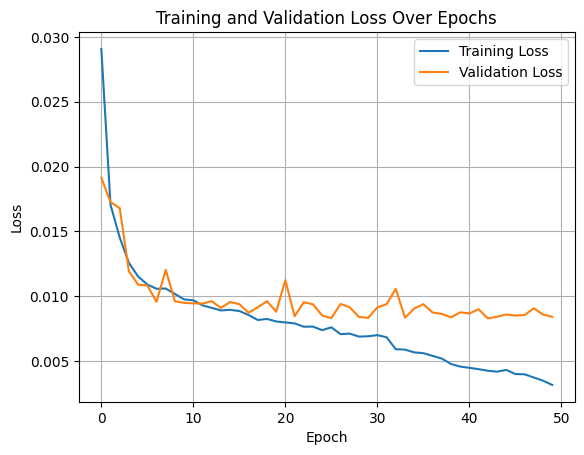

In [24]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Assuming you have your model, criterion, and optimizer defined
criterion = torch.nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Initialize the ReduceLROnPlateau scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_values = []
val_loss_values = []

num_epochs = 50
best_val_loss = float('inf')  # Initialize the best validation loss to infinity

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    
    # Training loop
    for imgs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)'):
        imgs, targets = imgs.to(device), targets.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Clear gradients
        outputs = model(imgs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        train_loss += loss.item()  # Accumulate training loss

    # Average training loss for this epoch
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Turn off gradient calculations for validation
        for imgs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
            imgs, targets = imgs.to(device), targets.to(device)  # Move data to GPU
            outputs = model(imgs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute validation loss
            val_loss += loss.item()  # Accumulate validation loss

    # Average validation loss for this epoch
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)

    # Print the losses for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Check if this is the best model so far and save the checkpoint
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss

    checkpoint = {
        'epoch': epoch + 1,  # Current epoch
        'model_state_dict': model.state_dict(),  # Model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
        'train_loss': train_loss,  # Last epoch's training loss
        'val_loss': val_loss  # Last epoch's validation loss
    }

    # Save the checkpoint (replace `save_checkpoint` with your saving function)
    save_checkpoint(checkpoint, is_best)
    
    # Step the scheduler with validation loss to adjust learning rate
    scheduler.step(val_loss)

# Plotting the loss
clear_output(wait=True)  # Clear the output to update the plot
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [25]:
# # Load the checkpoint
# checkpoint_path = "/kaggle/input/checkpoint-ssim-2/checkpoint_epoch_best.pth"
# checkpoint = torch.load(checkpoint_path)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# model.load_state_dict(checkpoint['model_state_dict'])
# start_epoch = checkpoint.get('epoch', 0)  # Starting from the checkpointed epoch

# train_loss_values = []
# val_loss_values = []

# num_epochs = 50
# best_val_loss = float('inf')
# patience = 10
# early_stop_counter = 0

# # Training loop
# for epoch in range(start_epoch, num_epochs):
#     model.train()
#     train_loss = 0.0

#     for imgs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Training)'):
#         imgs, targets = imgs.to(device), targets.to(device)
#         optimizer.zero_grad()  # Clear gradients
#         outputs = model(imgs)  # Forward pass
#         loss = criterion(outputs, targets)  # Compute loss
#         loss.backward()  # Backward pass
#         optimizer.step()  # Update weights
#         train_loss += loss.item()

#     # Average training loss for this epoch
#     train_loss /= len(train_loader)
#     train_loss_values.append(train_loss)

#     # Validation loop
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for imgs, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)'):
#             imgs, targets = imgs.to(device), targets.to(device)
#             outputs = model(imgs)  # Forward pass
#             loss = criterion(outputs, targets)  # Compute validation loss
#             val_loss += loss.item()

#     # Average validation loss for this epoch
#     val_loss /= len(val_loader)
#     val_loss_values.append(val_loss)

#     # Print the losses for this epoch
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#     is_best = val_loss < best_val_loss
#     if is_best:
#         best_val_loss = val_loss
#         early_stop_counter = 0

#         # Save the best model checkpoint
#         checkpoint = {
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_loss': train_loss,
#             'val_loss': val_loss
#         }
#         torch.save(checkpoint, '/kaggle/working/checkpoint_epoch_best.pth')
#     else:
#         early_stop_counter += 1

#     # Early stopping condition
#     if early_stop_counter >= patience:
#         print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {patience} consecutive epochs.")
#         break
        


# # Print the best validation loss
# print(f"Best Validation Loss: {best_val_loss:.4f}")

# # Plotting the loss
# plt.plot(range(start_epoch, epoch + 1), train_loss_values, label='Training Loss')
# plt.plot(range(start_epoch, epoch + 1), val_loss_values, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Epochs')
# plt.legend()
# plt.grid()
# plt.show()

In [31]:
!rm -rf /kaggle/working/*


In [33]:
import shutil

shutil.move('3d_MonaiUNET_slices_MSE_CONTRAST.pth')


TypeError: move() missing 1 required positional argument: 'dst'

In [32]:
torch.save(model.state_dict(), '3d_MonaiUNET_slices_MSE_CONTRAST.pth')

In [27]:
dataset_test = BrainMRIDataset(base_path='/kaggle/input/openbhb/val_quasiraw', volume_list=test_volumes)

Slices_test = SliceDatasetFromList(dataset_test)

test_loader = DataLoader(Slices_test, batch_size=8)


In [28]:
# checkpoint = torch.load("/kaggle/input/unet-mse-ssim/3d_MonaiUNET_slices_dense_SSIM_MSE.pth", weights_only=True)

# # model = UNETR_Reconstruction(in_channels=1, img_size=(16, 128, 128), feature_size=32, norm_name='instance')
# # model = model.to(device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # model_unet = UNet(
# #     spatial_dims=3,
# #     in_channels=1,
# #     out_channels=1,
# #     channels=(16, 32, 64, 128, 256),
# #     strides=(2, 2, 2, 2),
# #     num_res_units=2,
# #     norm=Norm.BATCH,
# # ).to(device)


# model.eval()

# print("Model loaded successfully.")


Testing:   0%|          | 0/13 [00:00<?, ?it/s]To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


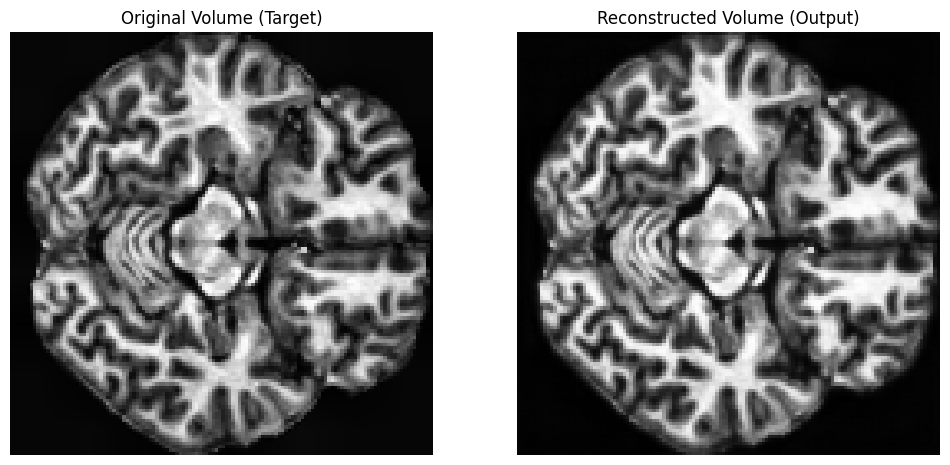

Testing:   8%|▊         | 1/13 [00:00<00:04,  2.45it/s]

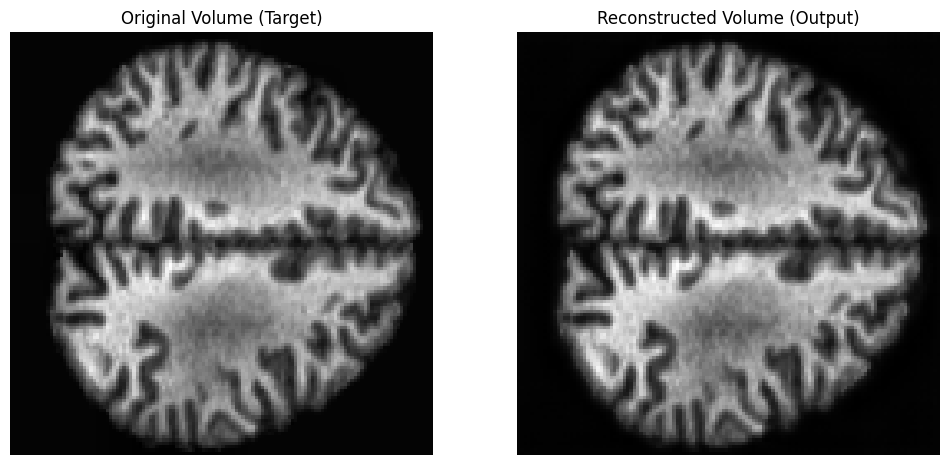

Testing:  15%|█▌        | 2/13 [00:00<00:04,  2.48it/s]

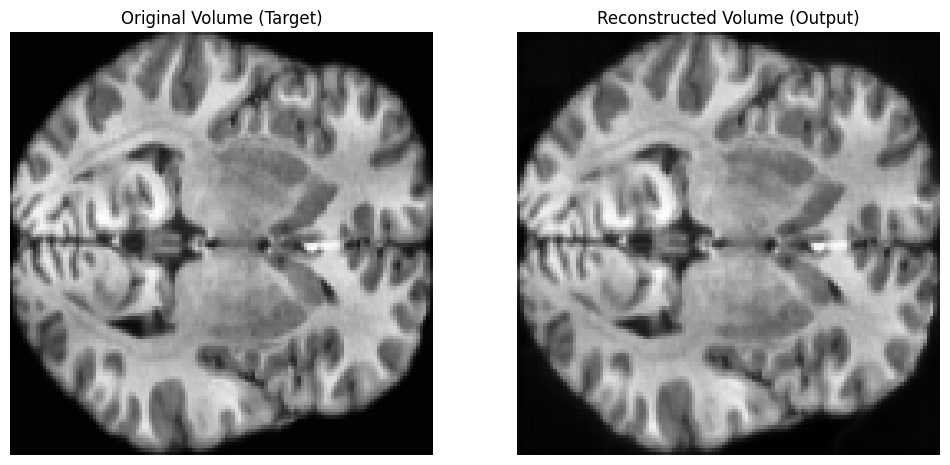

Testing:  23%|██▎       | 3/13 [00:01<00:04,  2.49it/s]

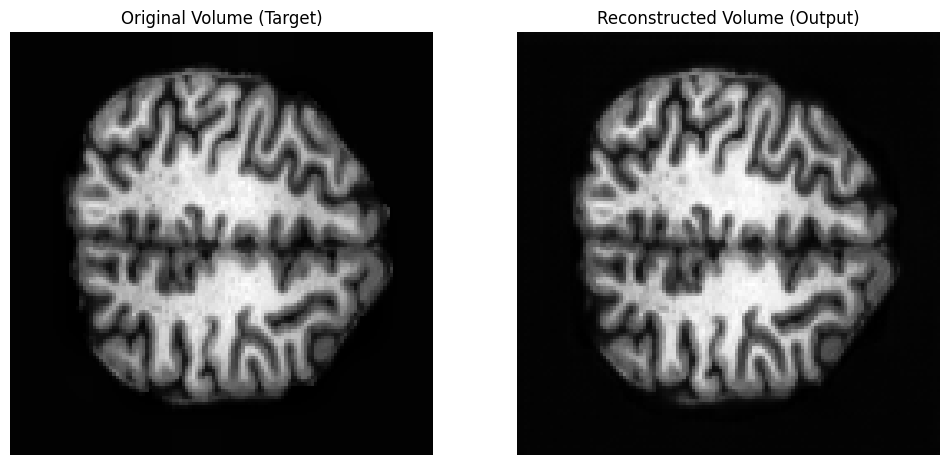

Testing:  31%|███       | 4/13 [00:01<00:03,  2.48it/s]

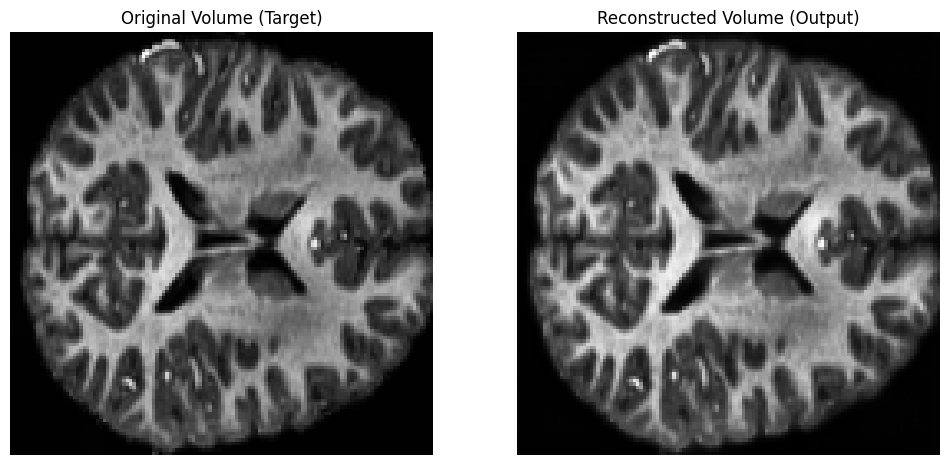

Testing:  38%|███▊      | 5/13 [00:02<00:03,  2.47it/s]

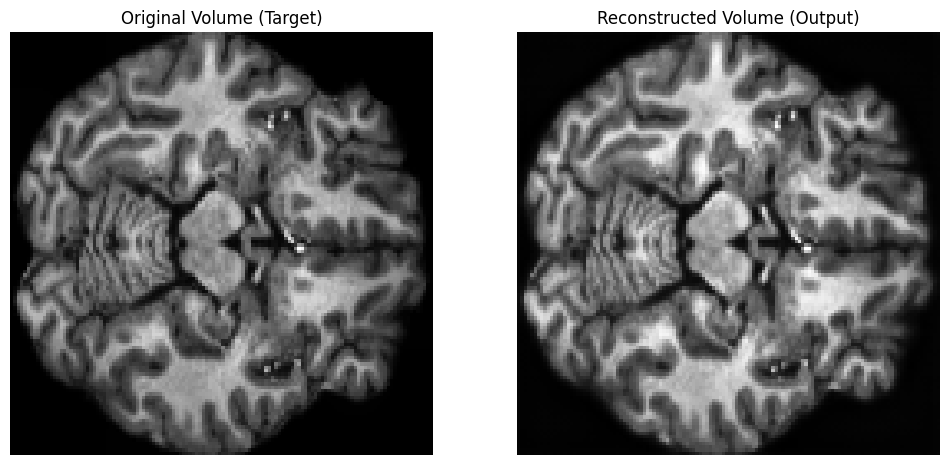

Testing:  46%|████▌     | 6/13 [00:02<00:02,  2.49it/s]

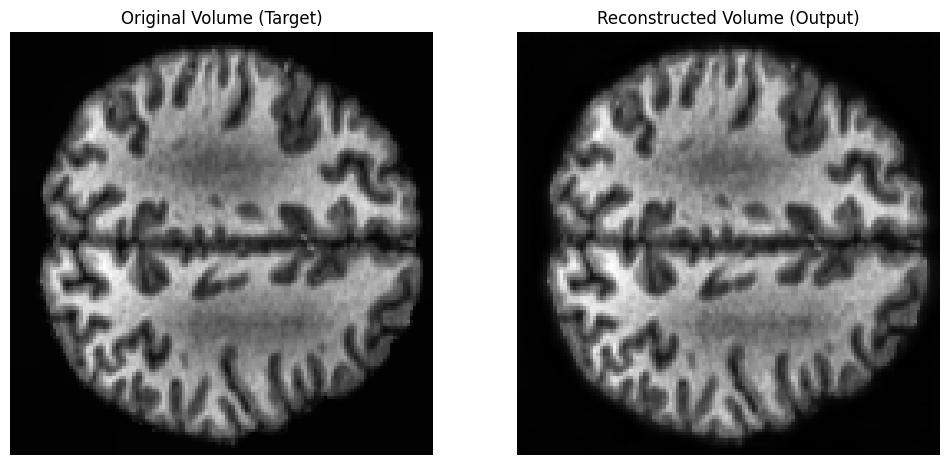

Testing:  54%|█████▍    | 7/13 [00:02<00:02,  2.50it/s]

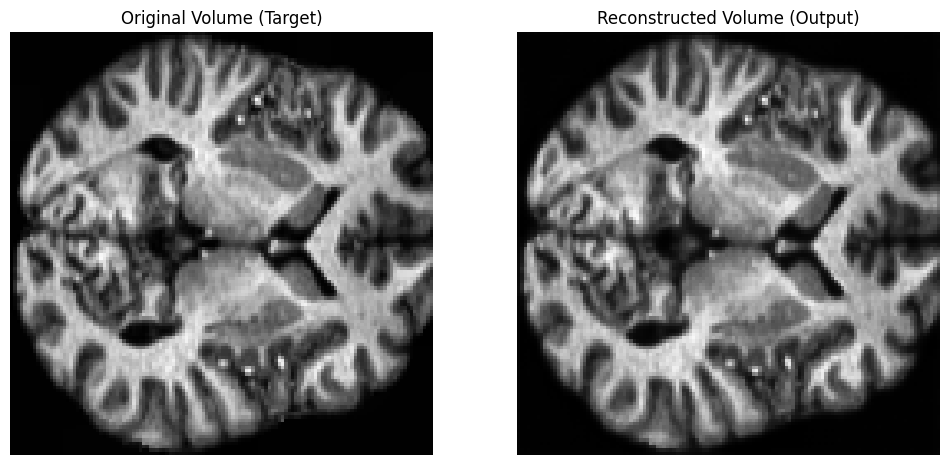

Testing:  62%|██████▏   | 8/13 [00:03<00:01,  2.50it/s]

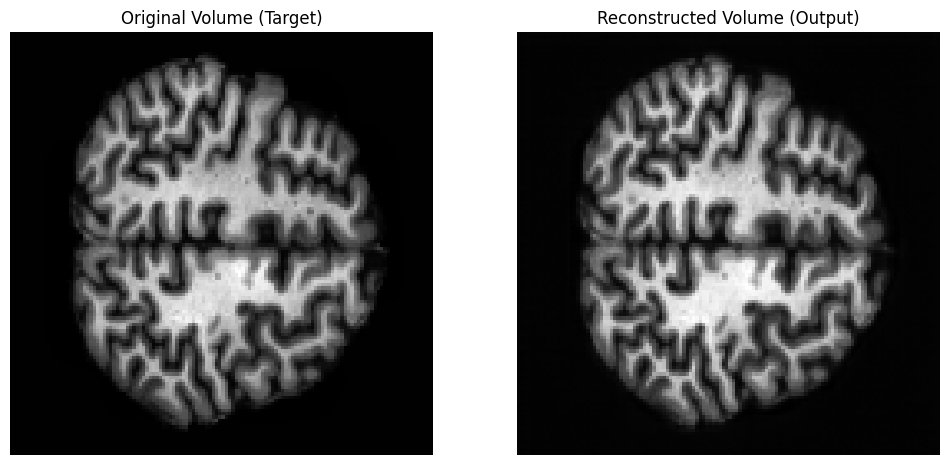

Testing:  69%|██████▉   | 9/13 [00:03<00:01,  2.50it/s]

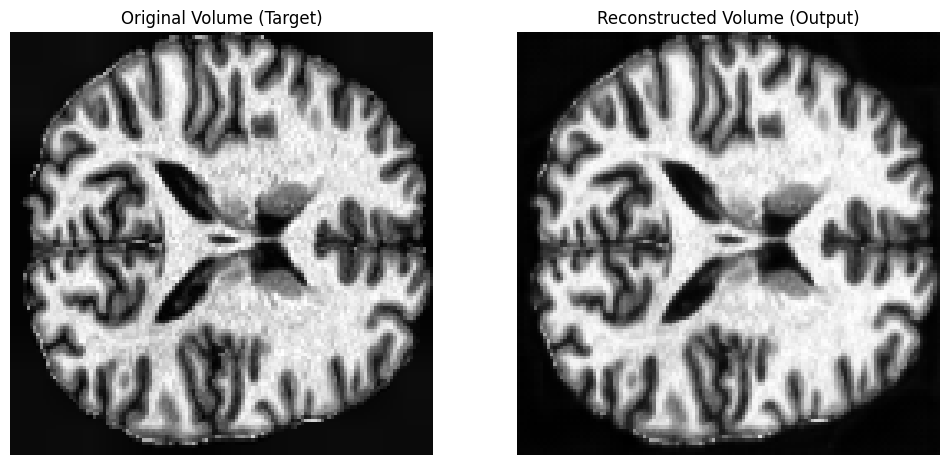

Testing:  77%|███████▋  | 10/13 [00:04<00:01,  2.50it/s]

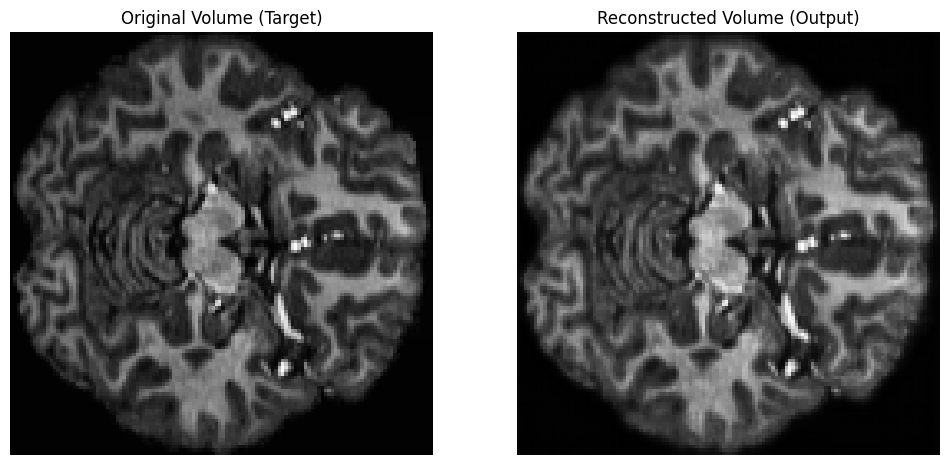

Testing:  85%|████████▍ | 11/13 [00:04<00:00,  2.51it/s]

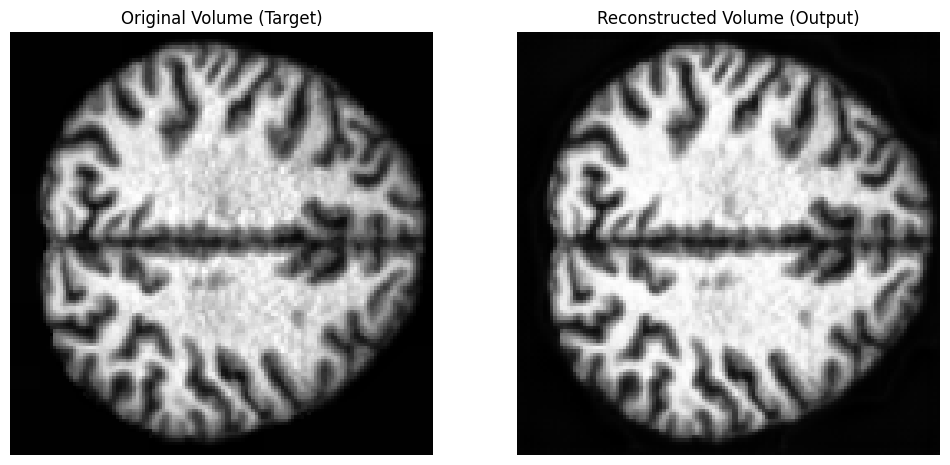

Testing:  92%|█████████▏| 12/13 [00:04<00:00,  2.50it/s]

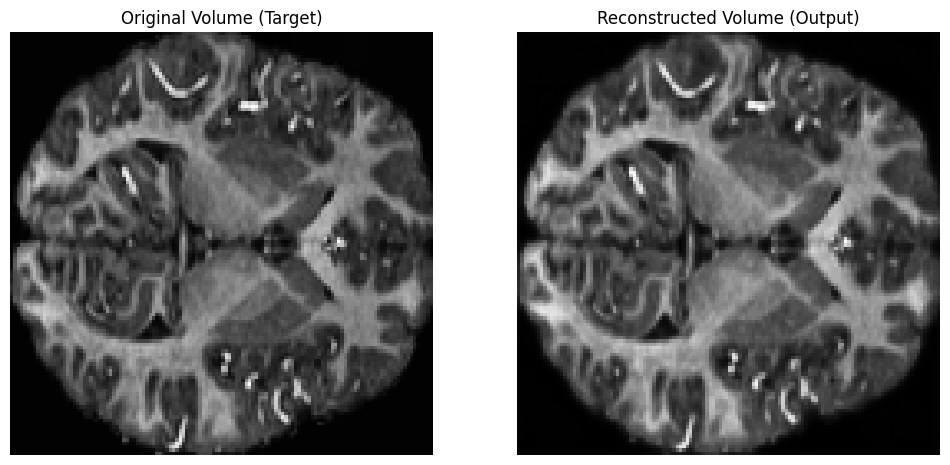

Testing: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]

Average Test Loss: 0.0000


In [29]:
import matplotlib.pyplot as plt
model.eval()
# Test loop
test_loss = 0.0

with torch.no_grad():  # Disable gradient calculations for testing
    for imgs, targets in tqdm(test_loader, desc='Testing'):
        imgs, targets = imgs.to(device), targets.to(device)  # Move data to GPU
        outputs = model(imgs)  # Forward pass
#         loss = criterion(outputs, targets)  # Compute test loss
#         test_loss += loss.item()  # Accumulate test loss

        # Visualize the input and reconstructed volume at depth 8
        depth = 8
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original Volume (Target)
        ax[0].imshow(targets[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[0].set_title('Original Volume (Target)')
        ax[0].axis('off')

        # Reconstructed Volume (Output)
        ax[1].imshow(outputs[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[1].set_title('Reconstructed Volume (Output)')
        ax[1].axis('off')

        plt.show()  # Display the plot

# Average test loss
test_loss /= len(test_loader)
print(f"Average Test Loss: {test_loss:.4f}")


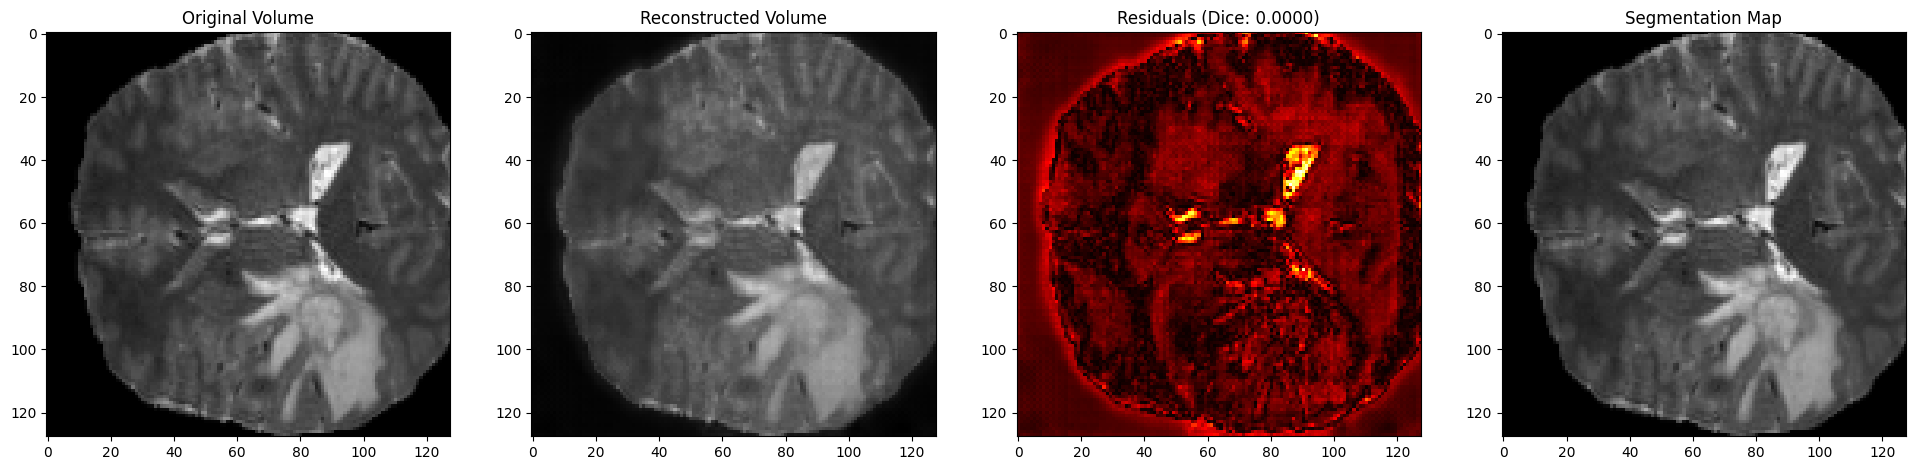

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_083: Dice Score: 0.0000


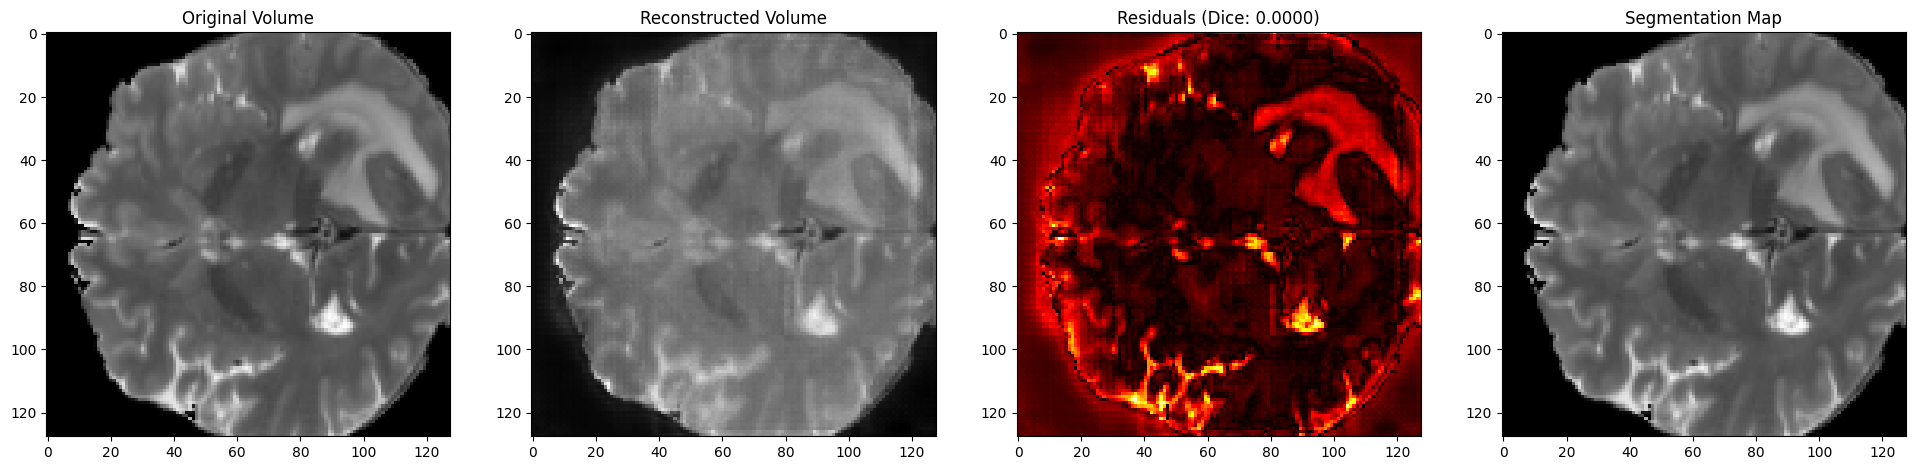

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_337: Dice Score: 0.0000


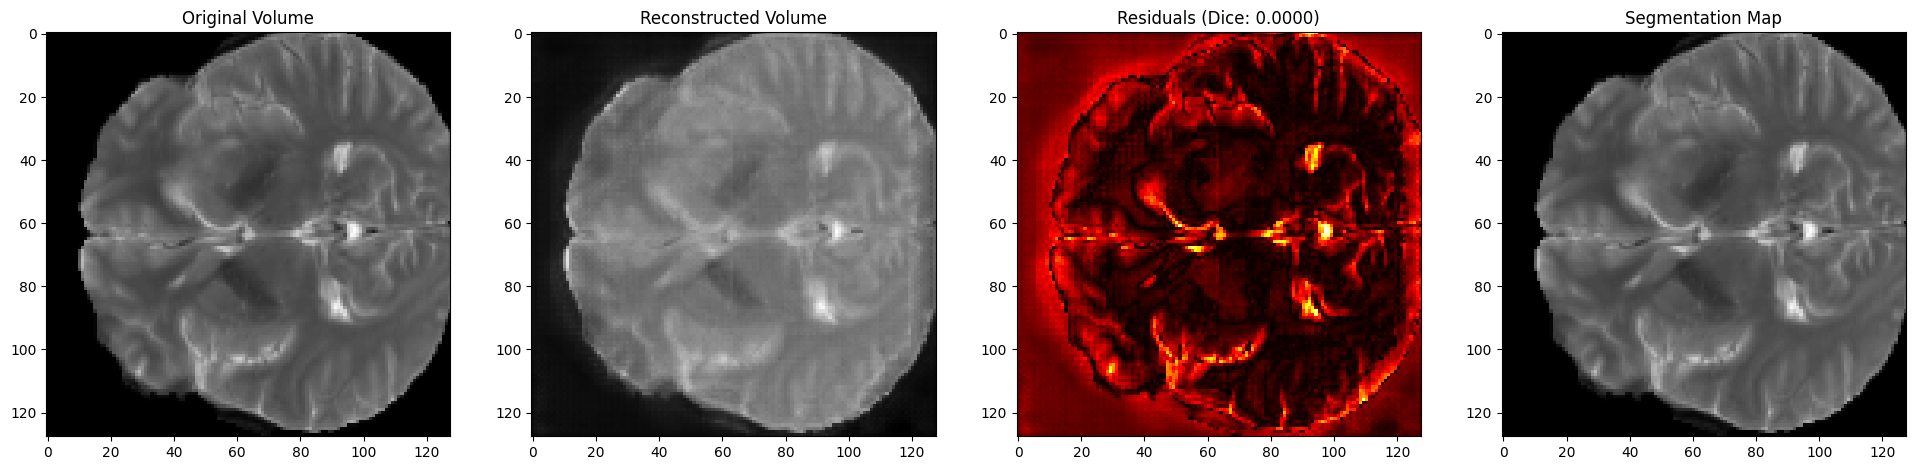

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_161: Dice Score: 0.0000


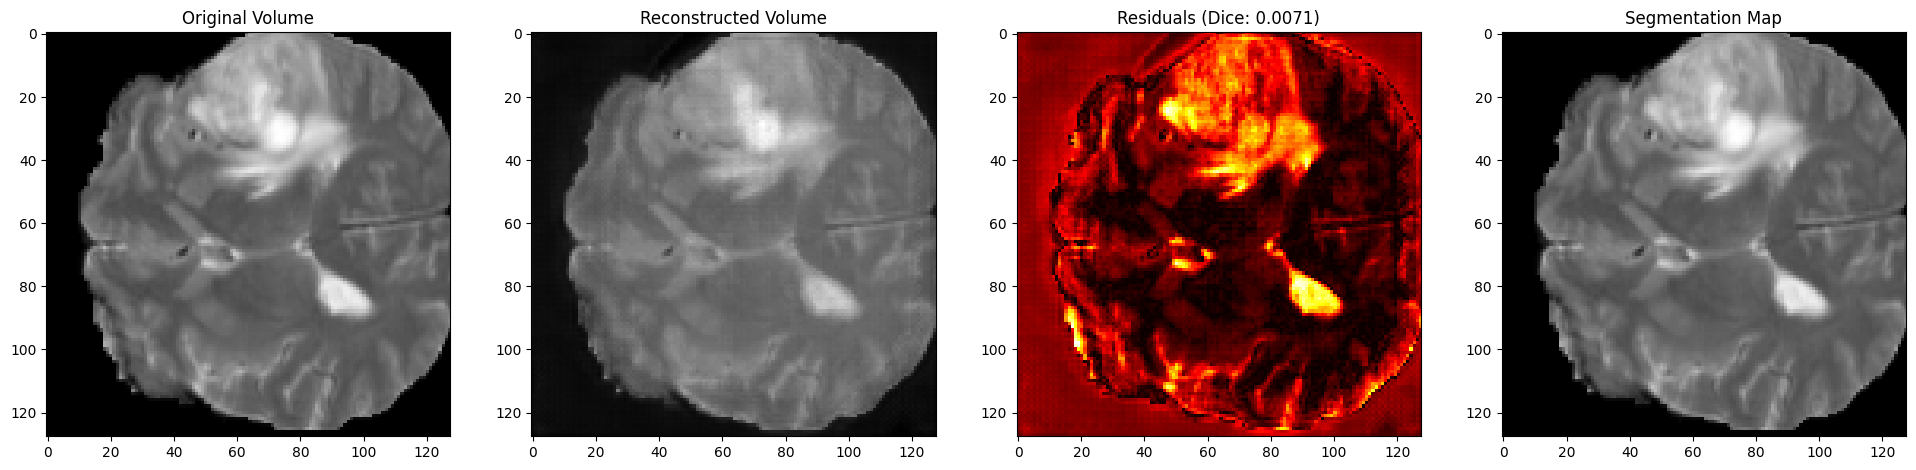

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_198: Dice Score: 0.0071


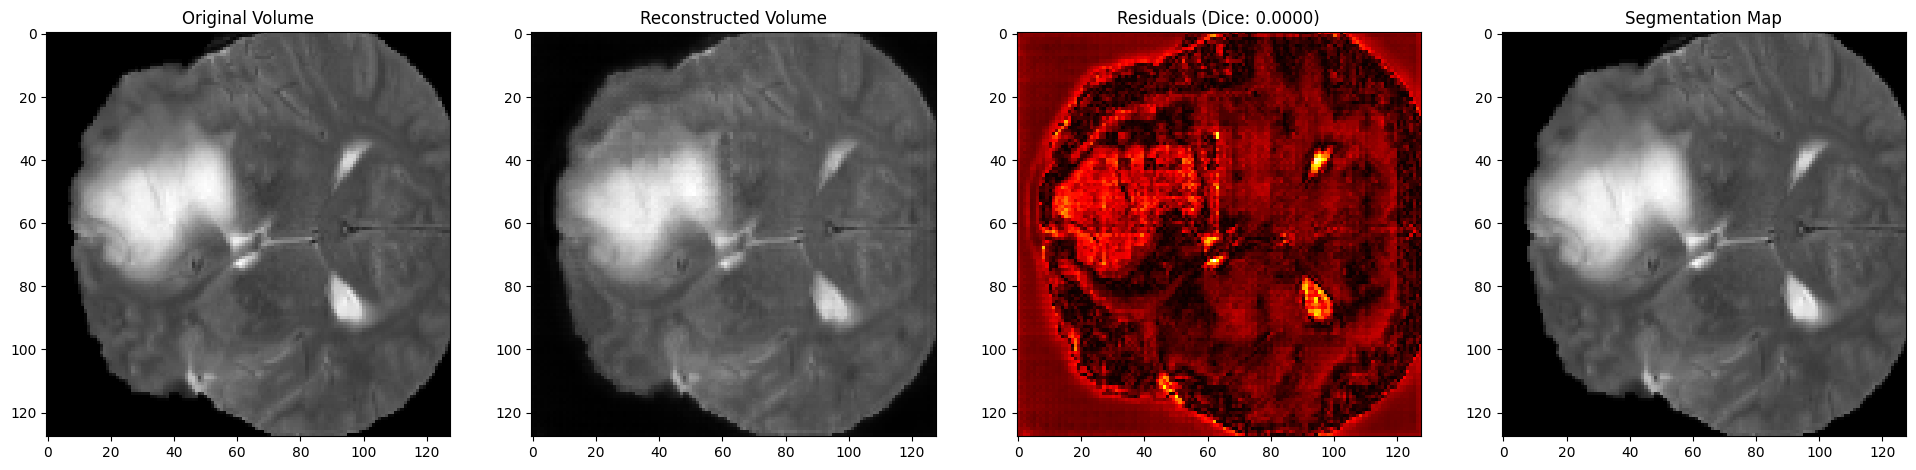

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_284: Dice Score: 0.0000


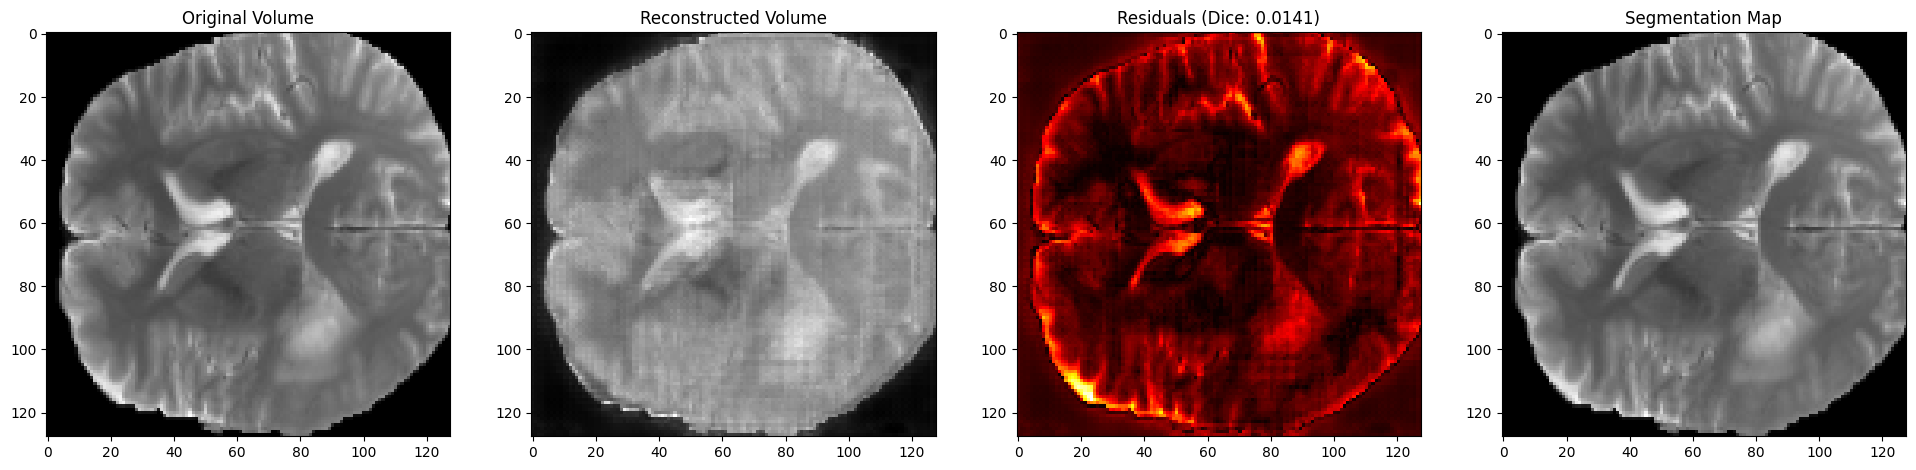

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_169: Dice Score: 0.0141


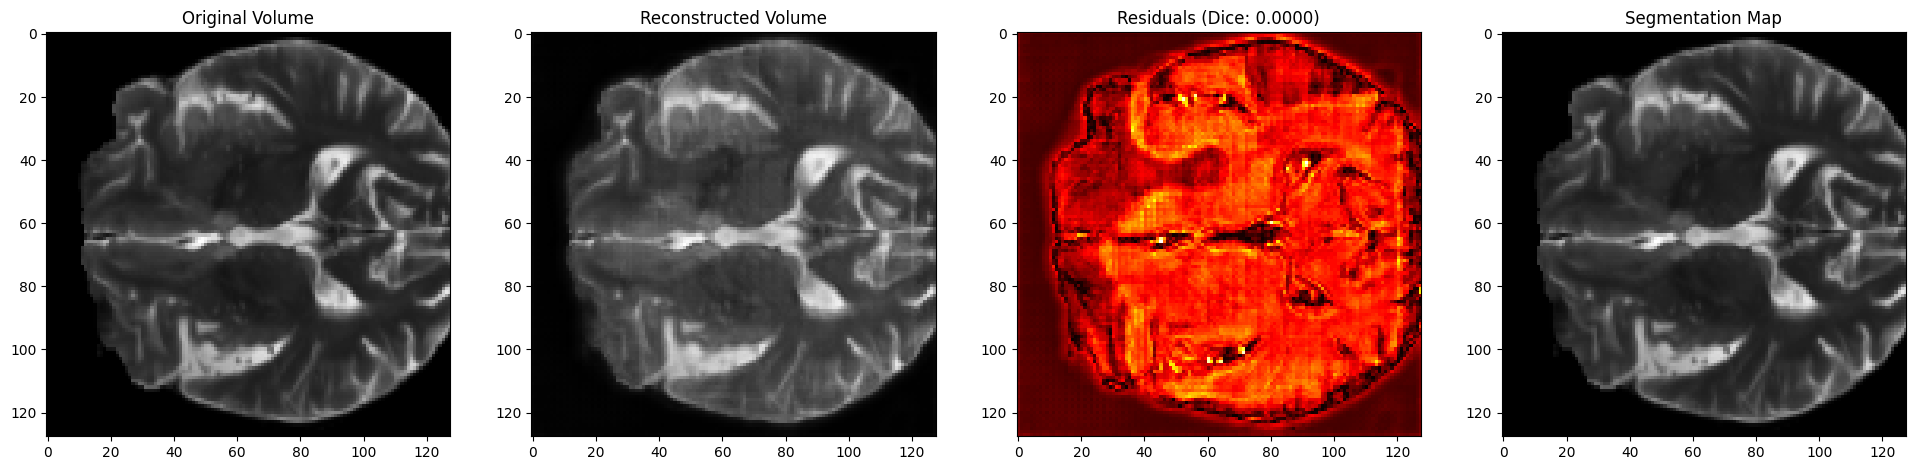

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_157: Dice Score: 0.0000


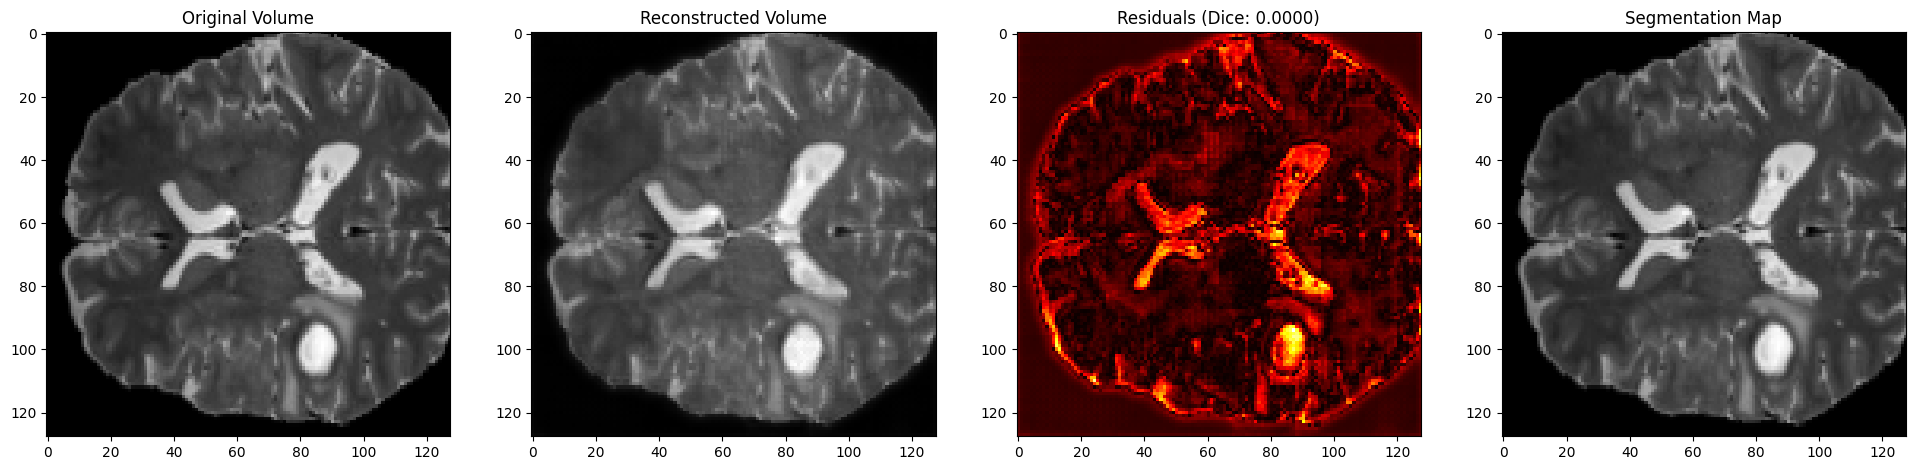

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_073: Dice Score: 0.0000


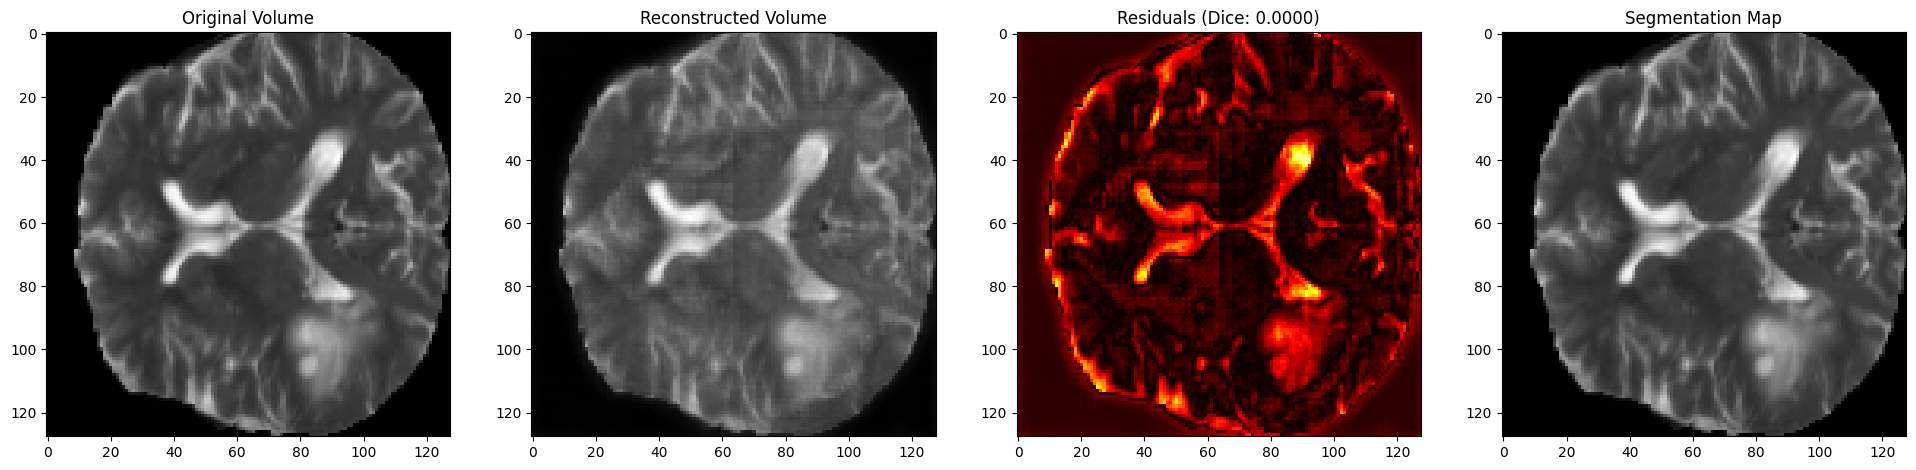

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_253: Dice Score: 0.0000


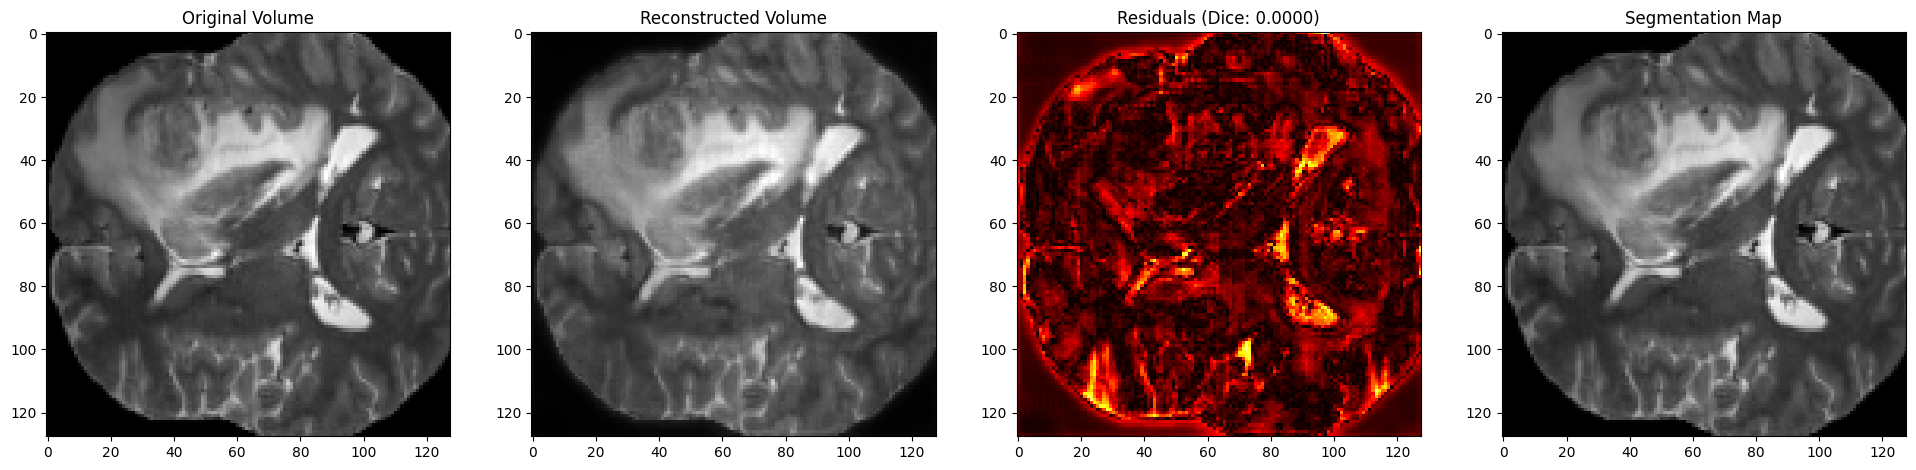

Processed /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_026: Dice Score: 0.0000


In [30]:
import nibabel as nib 
# Define the root directory where all subject subdirectories are stored
data_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# Define functions
def load_nifti_file(file_path):
    return nib.load(file_path).get_fdata()

def crop(mri_volume, crop_size=(160, 130, 170)):
    d, h, w = mri_volume.shape
    new_d, new_h, new_w = crop_size
    start_d = (d - new_d) // 2
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    return mri_volume[:, start_h:start_h+new_h, start_w:start_w+new_w]

def resize_volume(mri_volume):
    mri_tensor = torch.tensor(mri_volume, dtype=torch.float32)
    mri_resized = F.interpolate(
        mri_tensor.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        size=(mri_tensor.shape[0], 128, 128),  # Only resize height and width
        mode='trilinear',
        align_corners=False
    )
    return mri_resized

def get_slices(mri_volume):
    slices = []
    for i in range(8):
        start = i * 16
        end = start + 16
        slice_chunk = mri_volume[:, :, start:end, :, :]
        slices.append(slice_chunk)
    return slices

# Metric function for residual map evaluation
def calculate_residuals(true, predicted):
    return torch.abs(true - predicted)

# Dice score calculation function
def dice_score(true, predicted, threshold=0.5):
    true = true.cpu().numpy().flatten()
    predicted = (predicted.cpu().numpy() > threshold).astype(int).flatten()
    intersection = (true * predicted).sum()
    return (2. * intersection) / (true.sum() + predicted.sum())

# Loop through all subject subdirectories
subjects = [os.path.join(data_dir, subj) for subj in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subj))]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

subject_count = 10
curr_count = 0

for subject_dir in subjects:
    if curr_count < subject_count:
        # Construct paths for the T2-weighted MRI and segmentation files
        t2_path = os.path.join(subject_dir, [f for f in os.listdir(subject_dir) if '_t2.nii' in f][0])
        seg_path = t2_path.replace('_t1.nii', '_seg.nii')

        # Load the MRI and segmentation volumes
        t2_vol = load_nifti_file(t2_path)
        seg_vol = load_nifti_file(seg_path)
        
        # Normalize the volume to [0, 1]
        t2_norm = (t2_vol - np.min(t2_vol)) / (np.max(t2_vol) - np.min(t2_vol))


        # Preprocess the T2 MRI volume
        transpose_vol = np.transpose(t2_norm, (2, 0, 1))  # Reorient the volume
        cropped_vol = crop(transpose_vol)  # Crop
        resized_vol = resize_volume(cropped_vol)  # Resize

        # Preprocess the segmentation volume in the same way
        transpose_seg_vol = np.transpose(seg_vol, (2, 0, 1))  # Reorient the segmentation
        cropped_seg_vol = crop(transpose_seg_vol)  # Crop
        resized_seg_vol = resize_volume(cropped_seg_vol)  # Resize the segmentation to match the MRI

        # Split the volume into slices (both MRI and segmentation)
        slices_vol = get_slices(resized_vol)
        slices_seg = get_slices(resized_seg_vol)

        # Perform inference using the model
        with torch.no_grad():
            tensor_vol_slice = slices_vol[4].to(device)  # Taking the 5th chunk as an example (index 4)
            output = model(tensor_vol_slice)

            # Calculate the residuals
            residuals = calculate_residuals(tensor_vol_slice, output)

            # Extract the corresponding segmentation slice
            tensor_seg_slice = slices_seg[4].to(device)

            # Calculate Dice score as a metric
            dice = dice_score(tensor_seg_slice, residuals)

        # Plot example slices
        depth = 8  # Slice depth to visualize
        fig, ax = plt.subplots(1, 4, figsize=(24, 6))

        # Plot the original MRI volume slice
        ax[0].imshow(tensor_vol_slice[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[0].set_title('Original Volume')

        # Plot the reconstructed volume slice
        ax[1].imshow(output[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[1].set_title('Reconstructed Volume')

        # Plot the residual map slice
        ax[2].imshow(residuals[0, 0, depth, :, :].cpu().numpy(), cmap='hot')
        ax[2].set_title(f'Residuals (Dice: {dice:.4f})')

        # Plot the corresponding segmentation map slice
        ax[3].imshow(tensor_seg_slice[0, 0, depth, :, :].cpu().numpy(), cmap='gray')
        ax[3].set_title('Segmentation Map')

        plt.show()

        print(f"Processed {subject_dir}: Dice Score: {dice:.4f}")
    
    curr_count += 1